# Prepare the data

###### Define root directory for data.
This directory should already contain the test.zip and train.zip files from Kaggle.

In [6]:
DATA_PATH = "/Users/gzpjpk/dev/fastai/data/dogs-vs-cats-redux-kernels-edition"

In [4]:
from utils import *
from vgg16 import Vgg16
%matplotlib inline

Using TensorFlow backend.


###### Unzip data downloaded from Kaggle into `test/` and `train/` folders.

In [ ]:
!unzip $DATA_PATH/train.zip -d $DATA_PATH > /dev/null
!unzip $DATA_PATH/test.zip -d $DATA_PATH > /dev/null

In [ ]:
!mkdir    $DATA_PATH/valid
!mkdir    $DATA_PATH/results

!mkdir -p $DATA_PATH/sample/train
!mkdir    $DATA_PATH/sample/test
!mkdir    $DATA_PATH/sample/valid
!mkdir    $DATA_PATH/sample/results

###### Create validation dataset

In [ ]:
g = glob(DATA_PATH + '/train/*.jpg')
shuf = np.random.permutation(g)
for filepath in shuf[:2000]:
    os.rename(filepath, DATA_PATH+'/valid/' + os.path.basename(filepath))

###### Copy out some sample data

In [ ]:
from shutil import copyfile

def copyNFromTo(n, src, dest):
    g = glob(src + '/*.jpg')
    shuf = np.random.permutation(g)
    for i in range(n):
        filepath = shuf[i]
        copyfile(filepath, dest + '/' + os.path.basename(filepath))

        
copyNFromTo(200, DATA_PATH+'/train', DATA_PATH+'/sample/train')
copyNFromTo(50,  DATA_PATH+'/valid', DATA_PATH+'/sample/valid')
copyNFromTo(50,  DATA_PATH+'/test',  DATA_PATH+'/sample/test' )

###### Move cat and dog images into separate `dogs/` and `cats/` directories

In [ ]:
def separateDogsAndCats(dir):
    !mkdir "$dir/cats"
    !mkdir "$dir/dogs"
    for filepath in glob(dir + '/*.jpg'):
        filename = os.path.basename(filepath)
        if (filename.startswith('cat')): 
            os.rename(filepath, dir + '/cats/' + filename)
        elif (filename.startswith('dog')): 
            os.rename(filepath, dir + '/dogs/' + filename)
        else:
            raise Exception('Unexpected file: ' + filepath)
                
    
separateDogsAndCats(DATA_PATH + '/sample/train')
separateDogsAndCats(DATA_PATH + '/sample/valid')
separateDogsAndCats(DATA_PATH + '/valid')
separateDogsAndCats(DATA_PATH + '/train')

In [ ]:
def moveToUnknown(base_path):
    !mkdir $base_path/unknown
    for filepath in glob(base_path+'/*.jpg'):
        filename = os.path.basename(filepath)
        os.rename(filepath, base_path + '/unknown/' + filename)

moveToUnknown(DATA_PATH + '/test')
moveToUnknown(DATA_PATH + '/sample/test')

# Train VGG16 Neural Net

In [7]:
# path = DATA_PATH + '/sample' # use sample data
path = DATA_PATH # use real data

vgg = Vgg16()
batches = vgg.get_batches(path+'/train', batch_size=64)
val_batches = vgg.get_batches(path+'/valid', batch_size=128)
vgg.finetune(batches)

Found 24900 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [ ]:
latest_weights_filename = None

In [ ]:
no_of_epochs = 3

for epoch in range(no_of_epochs):
    print "Running epoch: %d" % epoch
    vgg.fit(batches, val_batches, nb_epoch=1)
    latest_weights_filename = 'ft%d.h5' % epoch
    vgg.model.save_weights(DATA_PATH + '/results/' + latest_weights_filename) # saving weights after each epoch
print "Completed %s fit operations" % no_of_epochs

# Generate Predictions

In [ ]:
batch_size = 64
batches, preds = vgg.test(path+'/test', batch_size = batch_size*2)

Verify the column ordering (appears that cats are column 1 and dogs are column 2) by viewing some images

In [ ]:
print preds[:5]
print batches.filenames[:5]

In [ ]:
from PIL import Image
Image.open(path + '/test/' + batches.filenames[0])

Save test results arrays

In [ ]:
save_array(path + '/results/test_preds.dat', preds)
save_array(path + '/results/filenames.dat', batches.filenames)

Kaggle requires the following format for new submissions:

```
imageId,isDog
1242, .3984
3947, .1000
4539, .9082
2345, .0000
```

Log Loss is used to evalutate submissions.

In [ ]:
preds = load_array(path + '/results/test_preds.dat')
filenames = load_array(path + '/results/filenames.dat')

# Validate Predictions

In [8]:
vgg.model.load_weights(DATA_PATH + '/results/ft2.h5')

In [10]:
val_batches, probs = vgg.test(DATA_PATH + '/valid', batch_size = 64)

Found 100 images belonging to 2 classes.


In [11]:
expected_labels = val_batches.classes #0 or 1

#Round our predictions to 0/1 to generate labels
our_predictions = probs[:,0]
our_labels = np.round(1-our_predictions)

In [14]:
from keras.preprocessing import image

#Helper function to plot images by index in the validation set 
#Plots is a helper function in utils.py
def plots_idx(idx, titles=None):
    plots([image.load_img(DATA_PATH + '/valid/' + val_batches.filenames[i]) for i in idx], titles=titles)
    
#Number of images to view for each visualization task
n_view = 4

Found 81 correct labels


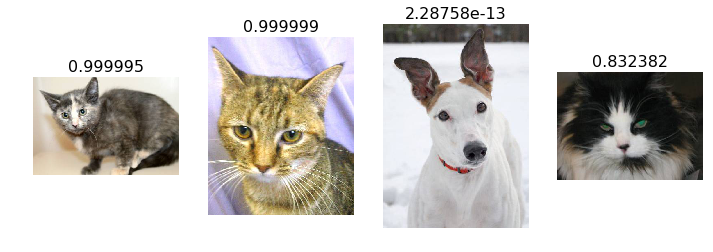

In [15]:
#1. A few correct labels at random
correct = np.where(our_labels==expected_labels)[0]
print "Found %d correct labels" % len(correct)
idx = permutation(correct)[:n_view]
plots_idx(idx, our_predictions[idx])

Found 19 incorrect labels


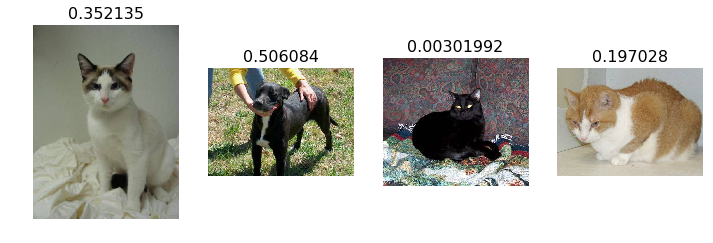

In [16]:
#2. A few incorrect labels at random
incorrect = np.where(our_labels!=expected_labels)[0]
print "Found %d incorrect labels" % len(incorrect)
idx = permutation(incorrect)[:n_view]
plots_idx(idx, our_predictions[idx])

Found 36 confident correct cats labels


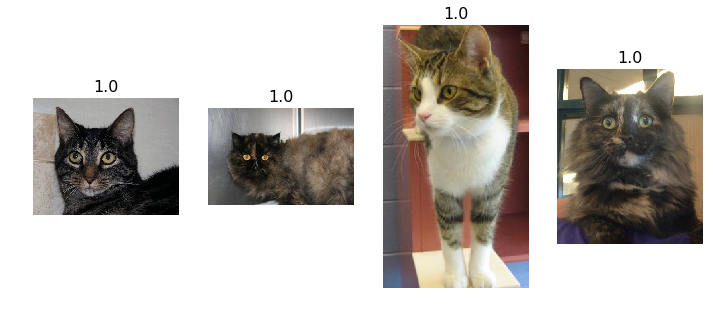

In [17]:
#3a. The images we most confident were cats, and are actually cats
correct_cats = np.where((our_labels==0) & (our_labels==expected_labels))[0]
print "Found %d confident correct cats labels" % len(correct_cats)
most_correct_cats = np.argsort(our_predictions[correct_cats])[::-1][:n_view]
plots_idx(correct_cats[most_correct_cats], our_predictions[correct_cats][most_correct_cats])

Found 45 confident correct dogs labels


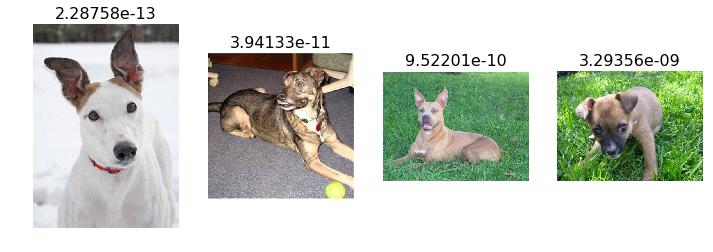

In [18]:
#3b. The images we most confident were dogs, and are actually dogs
correct_dogs = np.where((our_labels==1) & (our_labels==expected_labels))[0]
print "Found %d confident correct dogs labels" % len(correct_dogs)
most_correct_dogs = np.argsort(our_predictions[correct_dogs])[:n_view]
plots_idx(correct_dogs[most_correct_dogs], our_predictions[correct_dogs][most_correct_dogs])

Found 9 incorrect cats


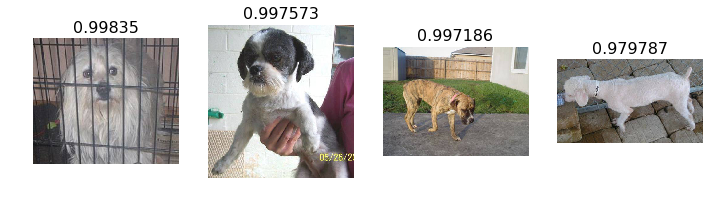

In [19]:
#4a. The images we were most confident were cats, but are actually dogs
incorrect_cats = np.where((our_labels==0) & (our_labels!=expected_labels))[0]
print "Found %d incorrect cats" % len(incorrect_cats)
if len(incorrect_cats):
    most_incorrect_cats = np.argsort(our_predictions[incorrect_cats])[::-1][:n_view]
    plots_idx(incorrect_cats[most_incorrect_cats], our_predictions[incorrect_cats][most_incorrect_cats])

Found 10 incorrect dogs


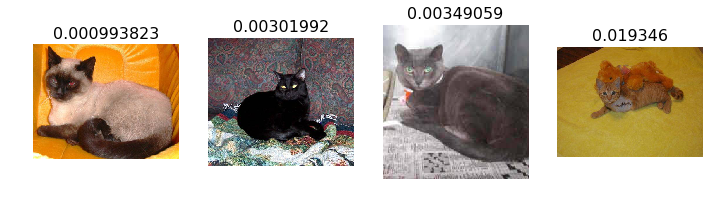

In [20]:
#4b. The images we were most confident were dogs, but are actually cats
incorrect_dogs = np.where((our_labels==1) & (our_labels!=expected_labels))[0]
print "Found %d incorrect dogs" % len(incorrect_dogs)
if len(incorrect_dogs):
    most_incorrect_dogs = np.argsort(our_predictions[incorrect_dogs])[:n_view]
    plots_idx(incorrect_dogs[most_incorrect_dogs], our_predictions[incorrect_dogs][most_incorrect_dogs])

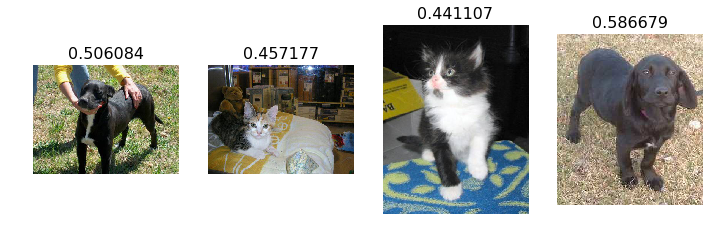

In [21]:
#5. The most uncertain labels (ie those with probability closest to 0.5).
most_uncertain = np.argsort(np.abs(our_predictions-0.5))
plots_idx(most_uncertain[:n_view], our_predictions[most_uncertain])

In [22]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(expected_labels, our_labels)

We can just print out the confusion matrix, or we can show a graphical view (which is mainly useful for dependents with a larger number of categories).

[[36 10]
 [ 9 45]]
[[36 10]
 [ 9 45]]


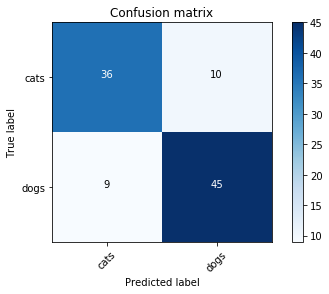

In [23]:
print cm
plot_confusion_matrix(cm, val_batches.class_indices)

# Create Kaggle Submission

Because log loss punishes confidently wrong answers more than it punishes confidently correct answers, tweak our results to be a bit less confident

In [ ]:
#Grab the dog prediction column
original_pred_percent = preds[:,1]
clipped_pred_percent = original_pred_percent.clip(min=0.05, max=0.95)

In [ ]:
#Extract imageIds from the filenames in our test/unknown directory 
ids = np.array([int(f[8:f.find('.')]) for f in batches.filenames])

Here we join the two columns into an array of [imageId, isDog]

In [ ]:
subm = np.stack([ids, clipped_pred_percent], axis=1)
subm[:5]

In [ ]:
submission_file_path = path + '/submission.csv'
np.savetxt(submission_file_path, subm, fmt='%d,%.5f', header='id,label', comments='')
print submission_file_path